In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import warnings

In [2]:
cache_dir="..\\data\\"

In [3]:
results_dir = os.path.join(cache_dir, "results", "23P-clean-subclass-col")
cumul_results_dir = os.path.join(results_dir, "cumulative")
cumul_results_dict = dict()
results_files = os.listdir(results_dir)
results_json_files = [f for f in results_files if f.endswith(".json")]
studied = [int(f[:6]) for f in results_json_files]  # cell nucleus ids of the studied cells
studied_str = str(len(studied))  # "_".join(map(str, studied))
results_fname = f"{studied_str}_clean_cells"  # CHANGE THIS when changing data
len(studied)

3

# Gather results

In [4]:
inh_cell_types = ['BC', 'MC', 'BPC', 'NGC']  # Basket Cell, Martinotti Cell, Bipolar Cell, Nuerogliaform Cells
cell_types = ['exc'] + inh_cell_types

# ### ---initialize results--- ###
# proportion of post-synaptic cells that are a given cell_type given the pre-synaptic cell is a lyer 2/3 pyramid
p_post_syn_type_given_pre = dict([(cell_type, 0.0) for cell_type in inh_cell_types])
p_post_syn_type_given_pres = dict()
ns = dict()  # synapses observed for each cell
n = 0  # total number of synapses observed
all_euc_hists = dict()  # cell-type histograms with euclidean distance for each cell
all_path_hists = dict()  # with distance along axon
all_euc_densities = dict()  # continuously moving bin to count proportion of each cell type with euclidean distance
all_path_densities = dict()
clean_output_df = pd.DataFrame()  # same as clean_output_df in synapse_analysis
syn_dfs = dict((t, pd.DataFrame()) for t in cell_types)  # same

for nuc_id in studied:
    possible_current_json_files = [f for f in results_json_files if f.startswith(str(nuc_id))]  # the jsons of the desired cell
    current_json_file = sorted(possible_current_json_files)[-1]  # should only be one, but if more than one, pick the most recent 
    with open(os.path.join(results_dir, current_json_file)) as f:
        data = json.loads(f.read())
        
    # parameters should all be the same, so we'll just use the last ones
    params = data["parameters"]
    if "pre_type" not in params:
        params["pre_type"] = "23P"  # 23P was the first pretype I used, and it wasn't labelled 
    max_hist_dist = params["max_hist_dist"]
    path_dist_step = params["path_dist_step"]
    euc_dist_step = params["euc_dist_step"]
    nsteps = params["nsteps"]
    pre_type = params["pre_type"]
    num_syns_cutoff = params["num_syns_cutoff"]
    cumul_results_dict["parameters"] = params
    
    clean_output_df = pd.concat([clean_output_df, pd.DataFrame(data["clean_output_dict"])], axis=0)
    for cell_type in cell_types:
         syn_dfs[cell_type] = pd.concat([syn_dfs[cell_type], pd.DataFrame(data["syn_dicts"][cell_type])], axis=0)

    p_post_syn_type_given_pres[nuc_id] = dict()
    for cell_type in inh_cell_types:
        pps = data[f"post_syn_{cell_type}_given_pre_{pre_type}"] if f"post_syn_{cell_type}_given_pre_{pre_type}" in data else data[f"post_syn_{cell_type}_given_pre_23P"]
        current_n = pps["n"]  # all of them have the same n
        p_post_syn_type_given_pre[cell_type] += pps["p"] * current_n  # divide by total n at the end
        p_post_syn_type_given_pres[nuc_id][cell_type] = pps["p"]
    n += current_n
    ns[nuc_id] = current_n
    
    all_euc_hists[nuc_id] = pd.DataFrame(data["euc_hists"])
    all_path_hists[nuc_id] = pd.DataFrame(data["path_hists"])
    all_euc_densities[nuc_id] = pd.DataFrame(data["euc_densities"])
    all_path_densities[nuc_id] = pd.DataFrame(data["path_densities"])
    
p_post_syn_type_given_pre = dict([(c, p_post_syn_type_given_pre[c] / n) for c in p_post_syn_type_given_pre])
p_post_syn_inh_given_pre = sum(p_post_syn_type_given_pre.values())

# agglomertated histograms
euc_hists = sum(all_euc_hists.values())  # this is just a count so sum
path_hists = sum(all_path_hists.values())
euc_densities = sum(all_euc_densities.values()) / len(studied)  # average it so that it's a density per cell
path_densities = sum(all_path_densities.values()) / len(studied)

## Results and Figures!

In [5]:
path_bin_edges = np.arange(0, max_hist_dist, path_dist_step)
path_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2

euc_bin_edges = np.arange(0, max_hist_dist, euc_dist_step)
euc_bin_centers = (path_bin_edges[1:] + path_bin_edges[:-1]) / 2

In [6]:
# continuously moving bucket to calculate synapse density of each type
# this implementation is a bit slow, but it's not that big a deal
# (I should rather loop over the synapses and increment appropriate counters as I go)
euc_bin_locs = np.linspace(euc_dist_step / 2, max_hist_dist - euc_dist_step / 2, nsteps)
path_bin_locs = np.linspace(path_dist_step / 2, max_hist_dist - path_dist_step / 2, nsteps)

In [7]:
# main result: the proportion of each cell type changes with distance from soma
p_type_by_path_dists = dict()
path_total_density = sum(path_densities[t] for t in path_densities)
for cell_type in path_densities:
    p_type_by_path_dists[cell_type] = path_densities[cell_type] / path_total_density
p_type_by_euc_dists = dict()
euc_total_density = sum(euc_densities[t] for t in euc_densities)
for cell_type in euc_densities:
    p_type_by_euc_dists[cell_type] = euc_densities[cell_type] / euc_total_density
    
# agglomerated data
all_p_type_by_path_dists = dict((cell_id, dict()) for cell_id in studied)
all_p_type_by_euc_dists = dict((cell_id, dict()) for cell_id in studied)
all_path_total_density = dict()
all_euc_total_density = dict()
for cell_id in studied:
    all_path_total_density[cell_id] = sum(all_path_densities[cell_id][t] for t in all_path_densities[cell_id])
    for cell_type in all_path_densities[cell_id]:
        all_p_type_by_path_dists[cell_id][cell_type] = all_path_densities[cell_id][cell_type] / all_path_total_density[cell_id]
    all_euc_total_density[cell_id] = sum(all_euc_densities[cell_id][t] for t in all_euc_densities[cell_id])
    for cell_type in all_euc_densities[cell_id]:
        all_p_type_by_euc_dists[cell_id][cell_type] = all_euc_densities[cell_id][cell_type] / all_euc_total_density[cell_id]

In [8]:
def to_list_dict(d):
    return dict((k, d[k].to_list()) for k in d)
cumul_results_dict["p_post_syn_type_given_pre"] = p_post_syn_type_given_pre
cumul_results_dict["p_type_by_path_dists"] = to_list_dict(p_type_by_path_dists)
cumul_results_dict["p_type_by_euc_dists"] = to_list_dict(p_type_by_euc_dists)
cumul_results_dict["euc_hists"] = euc_hists.to_dict()
cumul_results_dict["path_hists"] = path_hists.to_dict()
cumul_results_dict["euc_densities"] = euc_densities.to_dict()
cumul_results_dict["path_densities"] = path_densities.to_dict()

with open(os.path.join(cumul_results_dir, results_fname + "_cumulative.json"), "w") as f:
    f.write(json.dumps(cumul_results_dict))

In [9]:
plot_colors = ["lime", "gold", "orangered", "darkorchid", "dodgerblue"]
type_colors = dict(zip(cell_types, plot_colors))

## Agglomerated Data

In [10]:
n * p_post_syn_type_given_pre["NGC"]

0.0

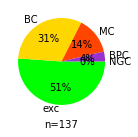

In [11]:
fig, ax = plt.subplots(figsize=(2, 2))
inh_ps = list(p_post_syn_type_given_pre.values())
ps = [1 - sum(inh_ps)] + inh_ps
ax.pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", counterclock=False)
ax.set_xlabel("n=" + str(n))
plt.show()

In [12]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_pie.png"))

In [13]:
# Possibly control for path distance in euclidean distance plot

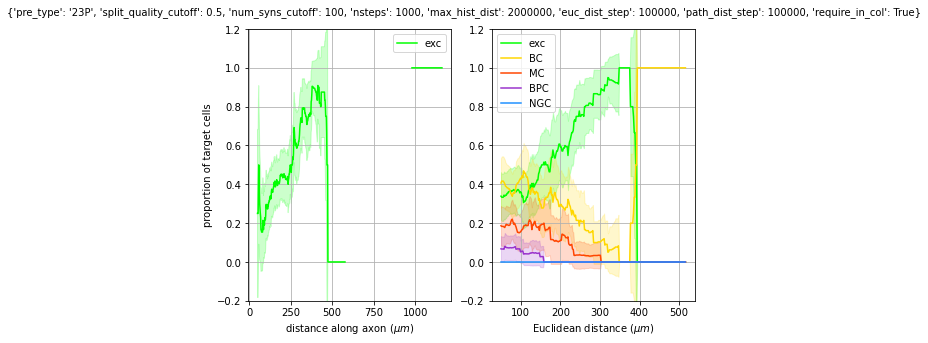

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
for cell_type in ["exc"]:  # cell_types:
    p = p_type_by_path_dists[cell_type]
    axes[0].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (path_dist_step * path_total_density * len(studied)))
    axes[0].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("proportion of target cells")
axes[0].legend()
axes[0].grid()
axes[0].set_ylim((-0.2, 1.2))
for cell_type in cell_types:
    p = p_type_by_euc_dists[cell_type]
    axes[1].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
    std_hat = np.sqrt(p * (1 - p) / (euc_dist_step * euc_total_density * len(studied)))
    axes[1].fill_between(euc_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
axes[1].set_ylim((-0.2, 1.2))
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [15]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_p_type.png"))

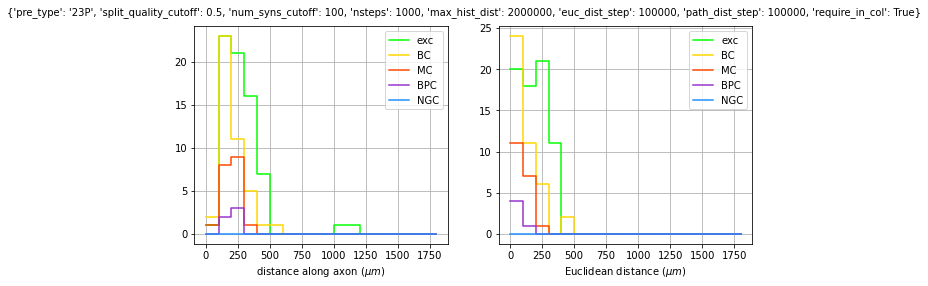

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    axes[0].step(path_bin_edges[:-1]/1000, path_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    axes[1].step(euc_bin_edges[:-1]/1000, euc_hists[cell_type], color=type_colors[cell_type], label=cell_type, where="post")
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [17]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_hists.png"))

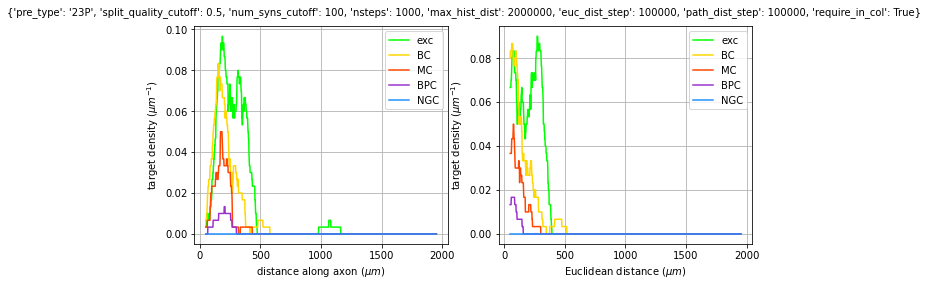

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    axes[0].plot(path_bin_locs/1000, 1000*path_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("target density ($\mu m^{-1}$)")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    axes[1].plot(euc_bin_locs/1000, 1000*euc_densities[cell_type], color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("target density ($\mu m^{-1}$)")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [19]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_densities.png"))

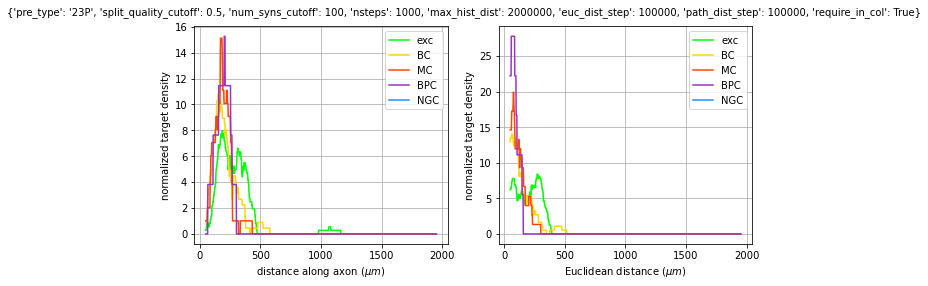

In [20]:
# normalized
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
for cell_type in cell_types:
    d = path_densities[cell_type]
    d = d / np.mean(d)
    axes[0].plot(path_bin_locs/1000, d, color=type_colors[cell_type], label=cell_type)
axes[0].set_xlabel("distance along axon ($\mu m$)")
axes[0].set_ylabel("normalized target density")
axes[0].legend()
axes[0].grid()
for cell_type in cell_types:
    d = euc_densities[cell_type]
    d = d / np.mean(d)
    axes[1].plot(euc_bin_locs/1000, d, color=type_colors[cell_type], label=cell_type)
axes[1].set_xlabel("Euclidean distance ($\mu m$)")
axes[1].set_ylabel("normalized target density")
axes[1].legend()
axes[1].grid()
fig.text(.5, 0.92, str(params), ha="center")
plt.show()

In [21]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_normalized_densities.png"))

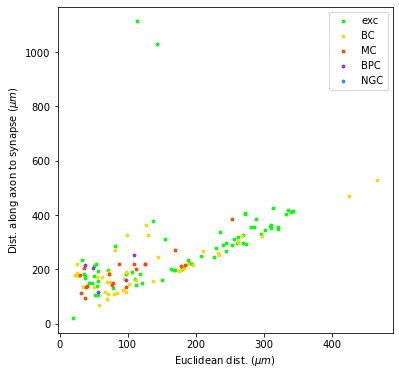

In [22]:
# plot euclidean distance to synapse vs path distance to synapse
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].euc_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("Euclidean dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [23]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_euc_v_path.png"))

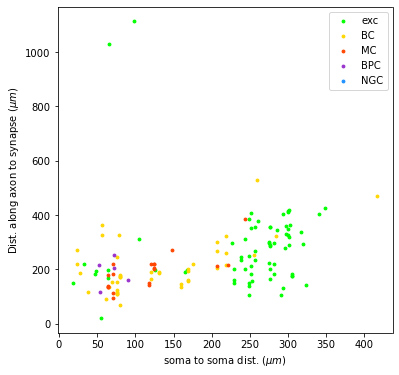

In [24]:
# plot path-distance along axon to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].path_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Dist. along axon to synapse ($\mu m$)")
plt.legend()
plt.show()

In [25]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_soma-soma_v_path.png"))

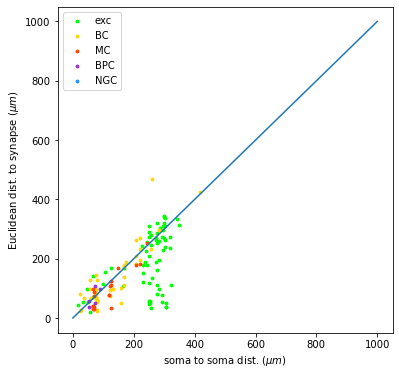

In [26]:
# plot euclidean distance to synapse vs distance from pre-soma to post-soma
fig, ax = plt.subplots(figsize=(6, 6))
for cell_type in syn_dfs:
    ax.scatter(syn_dfs[cell_type].soma_to_soma_dist / 1000, syn_dfs[cell_type].euc_dist / 1000, s=8, c=type_colors[cell_type], label=cell_type)
plt.plot([0, 1000], [0, 1000])
ax.set_xlabel("soma to soma dist. ($\mu m$)")
ax.set_ylabel("Euclidean dist. to synapse ($\mu m$)")
plt.legend()
plt.show()

In [27]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_soma-soma_v_euc.png"))

# visualizing soma-soma distance v synapse disance in neuroglancer
Also looking at the green outlier-ish points near the bottom

In [28]:
exc_idxs = list(range(len(syn_dfs["exc"])))
outlier_idxs = sorted(exc_idxs, key = lambda i: syn_dfs["exc"].soma_to_soma_dist.iloc[i] - syn_dfs["exc"].euc_dist.iloc[i])[-200:]

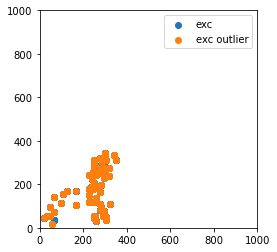

In [29]:
oidxs = np.random.choice(outlier_idxs, 200)
eidxs = np.random.choice(exc_idxs, 400)
plt.scatter(syn_dfs["exc"].soma_to_soma_dist.iloc[eidxs]/ 1000, syn_dfs["exc"].euc_dist.iloc[eidxs] / 1000, label="exc")
plt.scatter(syn_dfs["exc"].soma_to_soma_dist.iloc[oidxs]/ 1000, syn_dfs["exc"].euc_dist.iloc[oidxs] / 1000, label="exc outlier")
plt.xlim([0, 1000])
plt.ylim([0, 1000])
plt.gca().set_aspect(1)
plt.legend()

In [30]:
from caveclient import CAVEclient

datastack_name = "minnie65_phase3_v1"
client = CAVEclient(datastack_name)

all_cells = client.materialize.query_table("allen_soma_coarse_cell_class_model_v1")
cells_by_root = all_cells.copy()
cells_by_root.index = cells_by_root.pt_root_id
cells_by_nuc = all_cells.copy()
cells_by_nuc.index = cells_by_nuc.id

In [31]:
# This cell (864691136812081779) has more outlier synapses  (this might just be due to n)
o_syns = syn_dfs["exc"].iloc[outlier_idxs]
expected = []
observed = []
for nuc_id in studied:
    d = sum(o_syns.pre_pt_root_id == cells_by_nuc.pt_root_id.loc[nuc_id])
    print(nuc_id, cells_by_nuc.pt_root_id.loc[nuc_id], d, ns[nuc_id], 100 * d/ns[nuc_id])
    expected.append(ns[nuc_id] / n * 200)
    observed.append(d)

258307 864691135293126156 37 76 48.68421052631579
292713 864691136039640318 15 27 55.55555555555556
294657 864691134988768122 18 34 52.94117647058823


In [32]:
from scipy.stats import chisquare

In [33]:
list(zip(observed, map(lambda x: round(x), expected)))

[(37, 111), (15, 39), (18, 50)]

In [34]:
chisquare(observed, expected)

Power_divergenceResult(statistic=84.5749935500516, pvalue=4.3129408010108785e-19)

In [35]:
from nglui import statebuilder

image_path = 'precomputed://https://seungdata.princeton.edu/minnie65-phase3-em/aligned/v1'
segmentation_path = 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1'

img = statebuilder.ImageLayerConfig(image_path)
seg = statebuilder.SegmentationLayerConfig(segmentation_path)

In [36]:
points = statebuilder.PointMapper('ctr_pt_position', linked_segmentation_column='pre_pt_root_id')
anno_layer = statebuilder.AnnotationLayerConfig('o_syns', mapping_rules=points, linked_segmentation_layer=seg.name)

sb = statebuilder.StateBuilder([img, seg, anno_layer])

In [37]:
sb.render_state(o_syns, return_as='html')

The proximal-synapse excitatory target outliers seem to be short axons synapsing with the apical dendrites of deeper pyramids. https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://https://seungdata.princeton.edu/minnie65-phase3-em/aligned/v1%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22img%22%7D%2C%7B%22source%22:%22graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1%22%2C%22type%22:%22segmentation_with_graph%22%2C%22selectedAlpha%22:0.3%2C%22segments%22:%5B%2218446744073476563571%22%2C%22864691135780823632%22%2C%22864691136618404237%22%2C%22864691136812081779%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22graphOperationMarker%22:%5B%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%2C%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%5D%2C%22pathFinder%22:%7B%22color%22:%22#ffff00%22%2C%22pathObject%22:%7B%22annotationPath%22:%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%2C%22hasPath%22:false%7D%7D%2C%22name%22:%22seg%22%7D%2C%7B%22selectedAnnotation%22:%7B%22id%22:%2241999a3a80a51bc0d65c1e77fc70834026798cf1%22%7D%2C%22type%22:%22annotation%22%2C%22annotations%22:%5B%7B%22point%22:%5B273566%2C168136%2C15696%5D%2C%22type%22:%22point%22%2C%22id%22:%2211cdef0b1dd311600efe2fa49cb0b2a16d60b346%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B312334%2C161408%2C22784%5D%2C%22type%22:%22point%22%2C%22id%22:%22de4ac80bc160fd693f9ad50fd4d0fecd02ac04ed%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B350164%2C187298%2C22397%5D%2C%22type%22:%22point%22%2C%22id%22:%22a9ad70df1acf2ddd4177d0d56093450fb82f592e%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B278182%2C167718%2C16031%5D%2C%22type%22:%22point%22%2C%22id%22:%2241999a3a80a51bc0d65c1e77fc70834026798cf1%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B318586%2C176224%2C15403%5D%2C%22type%22:%22point%22%2C%22id%22:%22d54c10469fb2bb04c5cc3e1db914f5eb4c71a7b7%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B305388%2C160128%2C23639%5D%2C%22type%22:%22point%22%2C%22id%22:%22ab4fc52aaff472f03d7e0cf1880192ade4498f75%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B311801%2C164358%2C17864%5D%2C%22type%22:%22point%22%2C%22id%22:%22056b207c3b7bd19a3a4f18c060f3bdbf4f4fbc10%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B334184%2C167722%2C17344%5D%2C%22type%22:%22point%22%2C%22id%22:%220499f8e6ea3aa46492d554efaa593ec9aee620c5%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B314678%2C169198%2C21423%5D%2C%22type%22:%22point%22%2C%22id%22:%226bf435d3628d7c3d37b155f0643ec267ab7d33b3%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B335846%2C137334%2C15426%5D%2C%22type%22:%22point%22%2C%22id%22:%2205f6af515163ab52b4e29be7d9647504c543b8c5%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%2C%7B%22point%22:%5B329234%2C100466%2C18502%5D%2C%22type%22:%22point%22%2C%22id%22:%22c929730cdfba278a0632cf6c883c6606560284f9%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744073476563571%22%5D%7D%5D%2C%22annotationTags%22:%5B%5D%2C%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22linkedSegmentationLayer%22:%22seg%22%2C%22bracketShortcutsShowSegmentation%22:true%2C%22annotationSelectionShowsSegmentation%22:true%2C%22name%22:%22o_syns%22%7D%5D%2C%22navigation%22:%7B%22pose%22:%7B%22position%22:%7B%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22voxelCoordinates%22:%5B278182.40625%2C167718.359375%2C16031.849609375%5D%7D%7D%2C%22zoomFactor%22:18.975471672717056%7D%2C%22perspectiveOrientation%22:%5B-0.048757269978523254%2C0.17419981956481934%2C0.06561703234910965%2C0.9813111424446106%5D%2C%22perspectiveZoom%22:7380.246935540536%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22layer%22:%22o_syns%22%2C%22visible%22:true%7D%2C%22layout%22:%22xy-3d%22%7D

In [38]:
points = statebuilder.PointMapper('ctr_pt_position', linked_segmentation_column='pre_pt_root_id')
anno_layer = statebuilder.AnnotationLayerConfig('e_syns', mapping_rules=points, linked_segmentation_layer=seg.name)

sb = statebuilder.StateBuilder([img, seg, anno_layer])

In [39]:
e_syns = syn_dfs["exc"].iloc[eidxs].query("pre_pt_root_id == 864691135937286404")
sb.render_state(e_syns, return_as='html')

In [40]:
e_syns.query("post_pt_root_id == 864691136618413965")

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,soma_to_soma_dist,euc_dist,path_dist


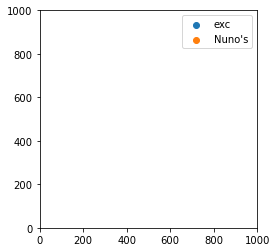

In [41]:
plt.scatter(e_syns.soma_to_soma_dist / 1000, e_syns.euc_dist / 1000, label="exc")
nunos = e_syns.query("post_pt_root_id == 864691136618413965")
plt.scatter(nunos.soma_to_soma_dist / 1000, nunos.euc_dist / 1000, label="Nuno's")
plt.xlim([0, 1000])
plt.ylim([0, 1000])
plt.gca().set_aspect(1)
plt.legend()

soma-to-soma distance $\approx$ euclidean distance to synapse: https://neuromancer-seung-import.appspot.com/#!%7B%22layers%22:%5B%7B%22source%22:%22precomputed://https://seungdata.princeton.edu/minnie65-phase3-em/aligned/v1%22%2C%22type%22:%22image%22%2C%22blend%22:%22default%22%2C%22shaderControls%22:%7B%7D%2C%22name%22:%22img%22%7D%2C%7B%22source%22:%22graphene://https://minnie.microns-daf.com/segmentation/table/minnie3_v1%22%2C%22type%22:%22segmentation_with_graph%22%2C%22selectedAlpha%22:0.3%2C%22segmentColors%22:%7B%22864691135278221217%22:%22#4dfffc%22%7D%2C%22segments%22:%5B%22864691135278221217%22%2C%22864691135937286404%22%2C%22864691135975465539%22%2C%22864691136618413965%22%5D%2C%22skeletonRendering%22:%7B%22mode2d%22:%22lines_and_points%22%2C%22mode3d%22:%22lines%22%7D%2C%22graphOperationMarker%22:%5B%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%2C%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%5D%2C%22pathFinder%22:%7B%22color%22:%22#ffff00%22%2C%22pathObject%22:%7B%22annotationPath%22:%7B%22annotations%22:%5B%5D%2C%22tags%22:%5B%5D%7D%2C%22hasPath%22:false%7D%7D%2C%22name%22:%22seg%22%7D%2C%7B%22selectedAnnotation%22:%7B%22id%22:%22a66ac612711e3b885dac1cb21929c4cb0416f83f%22%7D%2C%22type%22:%22annotation%22%2C%22annotations%22:%5B%7B%22point%22:%5B338318%2C140850%2C26010%5D%2C%22type%22:%22point%22%2C%22id%22:%22a66ac612711e3b885dac1cb21929c4cb0416f83f%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B302254%2C150722%2C24404%5D%2C%22type%22:%22point%22%2C%22id%22:%22508816560474897916719a981e5dd2a8b76c0650%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B297152%2C115608%2C24116%5D%2C%22type%22:%22point%22%2C%22id%22:%22642a1c2b4840e6bfa5cbce6eadbaa9dce510a267%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B358688%2C141270%2C23544%5D%2C%22type%22:%22point%22%2C%22id%22:%22684e1af6f3055fee5df1bfa299408448c418f149%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B310494%2C106348%2C22200%5D%2C%22type%22:%22point%22%2C%22id%22:%22e8e7079b456869c55b811021e8ce11bbec9ceb9d%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%2C%7B%22point%22:%5B313068%2C132112%2C23078%5D%2C%22type%22:%22point%22%2C%22id%22:%22dff5b7b83e726420b2fd1bcdcca119f0b2011e14%22%2C%22tagIds%22:%5B%5D%2C%22segments%22:%5B%2218446744072601768196%22%5D%7D%5D%2C%22annotationTags%22:%5B%5D%2C%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22linkedSegmentationLayer%22:%22seg%22%2C%22bracketShortcutsShowSegmentation%22:true%2C%22annotationSelectionShowsSegmentation%22:true%2C%22name%22:%22e_syns%22%7D%5D%2C%22navigation%22:%7B%22pose%22:%7B%22position%22:%7B%22voxelSize%22:%5B4%2C4%2C40%5D%2C%22voxelCoordinates%22:%5B310492.6875%2C106347.59375%2C22196.900390625%5D%7D%7D%2C%22zoomFactor%22:2%7D%2C%22perspectiveOrientation%22:%5B-0.031439196318387985%2C-0.3732105493545532%2C-0.16680458188056946%2C0.9120864272117615%5D%2C%22perspectiveZoom%22:7279.7438133281685%2C%22selectedLayer%22:%7B%22layer%22:%22seg%22%2C%22visible%22:true%7D%2C%22layout%22:%223d%22%7D

## Look for the bbox of a new column to study that hasn't been proofread

In [50]:
# use this cell if you want to go through the cells one at a time
# gather a list of thoroughly proofread layer 2/3 pyramidal cells
allow_clean = True
proofreading_status = client.materialize.query_table('proofreading_status_public_release')
pre_proofread_cells = proofreading_status.query(f"(status_axon == 'extended' or (status_axon == 'clean' and {allow_clean})) and valid_id == pt_root_id")
post_proofread_cells = proofreading_status.query(f"(status_axon == 'extended' or status_axon == 'clean') and valid_id == pt_root_id")
# proofread_cells = set.union(col_prf_root_ids, post_proofread_cells.pt_root_id.unique())  # cells that are clean according to either proofreading_status_public_release or allen_v1_column_pyc_proof 
# proofread_cells = proofreading_status.query("status_axon == 'extended' and valid_id == pt_root_id")
pre_type_cells = all_cells.query(f"cell_type == '{pre_type}'")
root_ids_to_study = list(set.intersection(set(pre_type_cells.pt_root_id.unique()), set(pre_proofread_cells.valid_id.unique())))
# if require_in_col:
#     root_ids_to_study = list(set.intersection(set(root_ids_to_study), col_cells.pt_root_id.unique()))
nucs_to_study = list(cells_by_root.id.loc[root_ids_to_study].values)  # permanent nucleus id of cell
print(len(root_ids_to_study), len(nucs_to_study))
if len(root_ids_to_study) != len(nucs_to_study):
    raise ValueError("Some cells were not proofread properly")

78 78


In [54]:
cells = cells_by_nuc.loc[nucs_to_study]

In [56]:
sb.render_state?

In [57]:
points = statebuilder.PointMapper('pt_position', linked_segmentation_column='id')
anno_layer = statebuilder.AnnotationLayerConfig('proofread_cells', mapping_rules=points, linked_segmentation_layer=seg.name)

sb = statebuilder.StateBuilder([img, seg, anno_layer])
sb.render_state(post_proofread_cells, return_as='html')

## Individual figures together

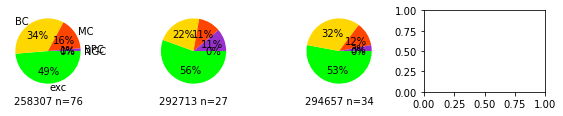

<Figure size 432x288 with 0 Axes>

In [42]:
fig, axs = plt.subplots((len(studied)  + 3) // 4, 4, figsize=(10, len(studied) / 2))
axes = axs.flatten()
inh_ps = list(p_post_syn_type_given_pres[studied[0]].values())
ps = [1 - sum(inh_ps)] + inh_ps
axes[0].pie(ps, labels=cell_types, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", counterclock=False)
axes[0].set_xlabel(str(studied[0]) + " n=" + str(ns[studied[0]]))
for i, cell_id in list(enumerate(studied))[1:]:
    inh_ps = list(p_post_syn_type_given_pres[cell_id].values())
    ps = [1 - sum(inh_ps)] + inh_ps
    axes[i].pie(ps, colors=plot_colors, autopct=lambda p: str(round(p)) + "%", pctdistance=0.6, counterclock=False)
    axes[i].set_xlabel(str(cell_id) + " n=" + str(ns[cell_id]))
plt.show()
plt.tight_layout()

In [43]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_pies.png"))

No handles with labels found to put in legend.


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

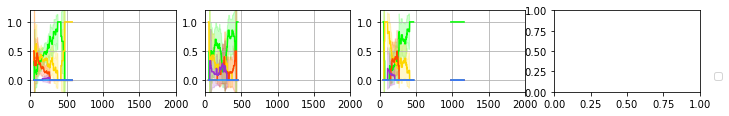

In [44]:
fig, axs = plt.subplots((len(studied) + 3) // 4, 4, figsize=(12, len(studied) / 2))
axes = axs.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        p = all_p_type_by_path_dists[cell_id][cell_type]
        axes[i].plot(path_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
        std_hat = np.sqrt(p * (1 - p) / (path_dist_step * all_path_total_density[cell_id]))
        axes[i].fill_between(path_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
#     axes[i].set_title("cell=" + str(cell_id))
    axes[i].grid()
    axes[i].set_ylim((-0.2, 1.2))
    axes[i].set_xlim((0, max_hist_dist/1000))
#     axes[i].set_xticklabels([''] * 4)
# axes[16].set_xticklabels([0, 500, 1000, 1500, 2000])
axes[3].legend(loc=(1.1, 0.15))
axs[-1, 0].set_xlabel("distance along axon ($\mu m$)")
axs[-1, 0].set_ylabel("proportion of target cells")
plt.show()
plt.tight_layout()

In [ ]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_p_types_path.png"))

In [ ]:
fig, axs = plt.subplots(len(studied) // 4 + 1, 4, figsize=(12, len(studied) / 2))
axes = axs.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        p = all_p_type_by_euc_dists[cell_id][cell_type]
        axes[i].plot(euc_bin_locs/1000, p, color=type_colors[cell_type], label=cell_type)
        std_hat = np.sqrt(p * (1 - p) / (euc_dist_step * all_euc_total_density[cell_id]))
        axes[i].fill_between(euc_bin_locs/1000, p - 2 * std_hat, p + 2 * std_hat, color=type_colors[cell_type], alpha=0.2)
    axes[i].grid()
    axes[i].set_ylim((-0.2, 1.2))
    axes[i].set_xlim((0, max_hist_dist/2000))
axes[3].legend(loc=(1.1, 0.15))
axs[-1, 0].set_xlabel("Euclidean distance ($\mu m$)")
axs[-1, 0].set_ylabel("proportion of target cells")
plt.show()
plt.tight_layout()

In [ ]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_p_types_euc.png"))

In [ ]:
fig, axs = plt.subplots((len(studied) + 3) // 4, 4, figsize=(12, len(studied) / 2))
axes = axs.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        axes[i].plot(path_bin_locs/1000, 1000*all_path_densities[cell_id][cell_type], color=type_colors[cell_type], label=cell_type)
    axes[i].grid()
    axes[i].set_ylim((0, 2))
axes[3].legend(loc=(1.1, 0.15))
axs[-1, 0].set_xlabel("distance along axon ($\mu m$)")
axs[-1, 0].set_ylabel("target density ($\mu m^{-1}$)")
plt.show()
plt.tight_layout()

In [ ]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_densities_path.png"))

In [ ]:
fig, axs = plt.subplots((len(studied) + 3) // 4, 4, figsize=(12, len(studied) / 2))
axes = axs.flatten()
for i, cell_id in enumerate(studied):
    for cell_type in cell_types:
        axes[i].plot(euc_bin_locs/1000, 1000*all_euc_densities[cell_id][cell_type], color=type_colors[cell_type], label=cell_type)
    axes[i].grid()
    axes[i].set_ylim((0, 2.2))
axes[3].legend(loc=(1.1, 0.15))
axs[-1, 0].set_xlabel("Euclidean distance ($\mu m$)")
axs[-1, 0].set_ylabel("target density ($\mu m^{-1}$)")
plt.show()
plt.tight_layout()

In [ ]:
fig.savefig(os.path.join(cumul_results_dir, results_fname + "_all_densities_euc.png"))

# Miscellaneous

## See if there's anything interesting going on with number of synapses formed between pairs of cells
Correlation between number of synapses between two cells and the soma-soma distance, average path distance, or average euclidean distance to the synapse

In [151]:
clean_output_df["num_syns"] = clean_output_df.groupby(["pre_pt_root_id", "post_pt_root_id"]).transform("count")["id"]

In [152]:
clean_output_df

,ctr_pt_position,id,post_pt_position,post_pt_root_id,post_pt_supervoxel_id,pre_pt_level2_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,valid,skel_idx,post_pt_level2_id,post_pt_mesh_ind,soma_to_soma_dist,euc_dist,path_dist,num_syns
1,"[293522, 147748, 26411]",349904061,"[293492, 147798, 26409]",864691135570739693,105142587589245793,1.772002e+17,349.0,"[293550, 147722, 26415]",864691135937286404,105142587589248845,4984,t,249,NaN,NaN,302631.491607,288515.885178,406258.002281,1
3,"[324832, 176170, 24522]",404991590,"[324822, 176244, 24527]",864691136536079010,109438860287021951,1.814965e+17,7470.0,"[324870, 176182, 24517]",864691135937286404,109438860287009992,9164,t,3283,NaN,NaN,469767.037549,226724.808135,346531.519348,1
4,"[339498, 136072, 26228]",432641298,"[339466, 136144, 26225]",864691135695952538,111403825272881331,1.835318e+17,10687.0,"[339568, 136096, 26223]",864691135937286404,111474194017051993,12812,t,4724,NaN,NaN,243127.039582,260071.288442,454764.199829,3
5,"[258344, 201644, 22693]",296557493,"[258322, 201634, 22693]",864691136617334747,100294359316104108,1.723520e+17,25.0,"[258352, 201712, 22694]",864691135937286404,100294359316104182,3472,t,19,NaN,NaN,277477.673221,371614.578831,475777.330688,2
8,"[350752, 147382, 26083]",445215606,"[350800, 147384, 26087]",864691136945679327,113023818150753858,1.850110e+17,11523.0,"[350702, 147422, 26076]",864691135937286404,112953449406561883,20012,t,5119,NaN,NaN,306046.482639,267623.464323,454145.014893,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,"[215806, 133710, 22806]",224081694,"[215852, 133762, 22802]",864691136174962694,94444613859091446,1.665022e+17,11602.0,"[215790, 133788, 22812]",864691136039640318,94444613859106854,18776,t,5422,NaN,NaN,144898.155682,146085.651150,445531.878387,1
575,"[174687, 194933, 19142]",151701776,"[174680, 194938, 19139]",864691136105687001,88823360192231781,1.608106e+17,3346.0,"[174554, 194894, 19141]",864691136039640318,88752991448053427,15044,t,1617,NaN,NaN,320058.067631,309339.117630,386785.083679,2
576,"[211884, 134238, 21720]",214443585,"[211810, 134314, 21726]",864691135415817402,93881732490872271,1.659393e+17,11453.0,"[211958, 134306, 21721]",864691136039640318,93881732490879580,13928,t,5325,NaN,NaN,306614.282564,126056.283302,267744.717010,1
583,"[183708, 130512, 21873]",174328728,"[183652, 130528, 21868]",864691135474752320,90010970524959605,NaN,NaN,"[183650, 130546, 21880]",864691136039640318,90010970524974714,860,t,3038,1.620686e+17,6966.0,214231.016989,32141.810777,32850.378876,1


In [174]:
from scipy.stats import pearsonr, gamma

In [156]:
r, p = pearsonr(clean_output_df.soma_to_soma_dist, clean_output_df.num_syns)
r, p, r**2  # this result might be obvious just due to the fact that more synapses form proximally

(-0.146304470409582, 2.252372164481527e-50, 0.021404998061828256)

In [197]:
# now try again with only one data point per pre-post-pair, rather than per synapse
soma_dists = []
num_syns = []
path_dists = []
euc_dists = []
pre_post_pairs = np.unique(list(zip(clean_output_df.pre_pt_root_id, clean_output_df.post_pt_root_id)), axis=0)
for pre_id, post_id in pre_post_pairs:
    conn = clean_output_df.query(f"pre_pt_root_id == {pre_id} and post_pt_root_id == {post_id}")
    soma_dists.append(conn.soma_to_soma_dist.iloc[0])
    num_syns.append(conn.num_syns.iloc[0])
    path_dists.append(conn.path_dist.values)
    euc_dists.append(conn.euc_dist.values)
    

In [172]:
r, p = pearsonr(soma_dists, num_syns)
r, p, r**2  # this result might be obvious just due to the fact that more synapses form proximally

(-0.09976132298408119, 3.039245548090911e-20, 0.009952321563534166)

In [200]:
r, p = pearsonr(list(map(np.mean, path_dists)), num_syns)
r, p, r**2  # this result might be obvious just due to the fact that more synapses form proximally

(-0.10720849999823454, 3.7850749890473145e-23, 0.011493662471871455)

In [201]:
r, p = pearsonr(list(map(np.mean, euc_dists)), num_syns)
r, p, r**2  # this result might be obvious just due to the fact that more synapses form proximally

(-0.09365095066707803, 5.131328784521374e-18, 0.008770500560847482)

### Make a fake population of cells with a gamma distribution of soma-soma distances and see if the same correlation exists
I could alternatively not do any simulation. Rather, look at the probability of cell A forming another synapse with cell B given one already exists at distance d.

In [312]:
nfake = 400
npre = 50  # pre is a subset of fake--the closest ones to the center
scale = 12
fake_cell_locs = (np.random.random((nfake, 3)) - 0.5) * scale
fake_pre_locs = fake_cell_locs[np.argsort(np.sum(fake_cell_locs ** 2, axis=1))[:npre]]

In [331]:
fake_synapses = np.zeros((npre, nfake))
fake_soma_dists = np.zeros((npre, nfake))
ds = []
ntries = 50
likelihood = 1
a = 1.01
for pre in range(npre):
    print(pre)
    for post in range(nfake):
        pre_loc = fake_pre_locs[pre]
        d = np.sqrt(np.sum((pre_loc - fake_cell_locs[post])**2))
        fake_soma_dists[pre, post] = d
        l = gamma.pdf(d, a) * likelihood
        num_syns = sum(np.random.random(size=ntries) < l)
        fake_synapses[pre, post] += num_syns
        ds.extend([d] * num_syns)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


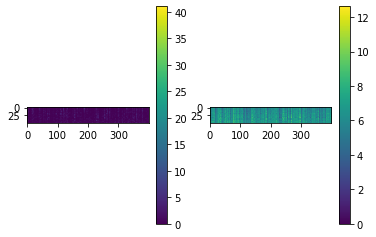

In [332]:
# fig, axes = plt.subplots(1, 2)
plt.subplot(121)
plt.imshow(fake_synapses)
plt.colorbar()
plt.subplot(122)
plt.imshow(fake_soma_dists)
plt.colorbar()

In [333]:
r, p = pearsonr(fake_soma_dists.flatten()[syn_idxs], fake_synapses.flatten()[syn_idxs])
r, p, r**2  # this suggests that in real data, farther away cells "actively" form multiple synapses when connecting with
# farther cells, although this simulation is not conculsive

(-0.6412782571885243, 0.0, 0.4112378031427511)

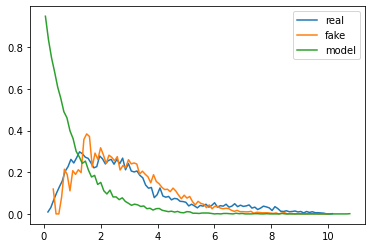

In [334]:
# the shapes don't match because there are more cells far away than close by
soma_dists_model = gamma.rvs(a=a, size=len(soma_dists))

soma_hist, edge = np.histogram(np.array(soma_dists) / 100000, bins=100, density=True)
model_hist, edge_model = np.histogram(soma_dists_model, bins=100, density=True)
fake_soma_hist, edge_fake = np.histogram(ds, bins=100, density=True)

bin_centers = (edge[1:] + edge[:-1]) / 2
bin_centers_model = (edge_model[1:] + edge_model[:-1]) / 2
bin_centers_fake = (edge_fake[1:] + edge_fake[:-1]) / 2
plt.plot(bin_centers, soma_hist, label="real")
plt.plot(bin_centers_fake, fake_soma_hist, label="fake")
plt.plot(bin_centers_model, model_hist, label="model")
plt.legend()

In [53]:
prf = client.materialize.query_table("allen_v1_column_pyc_proof")

In [57]:
864691135293126156 in prf.pt_root_id

False

In [56]:
prf

,id,valid,classification_system,cell_type,pt_supervoxel_id,pt_root_id,pt_position
0,1,t,dendrites_clean,clean,90505063495624451,864691135478396358,"[186944, 141984, 21399]"
1,2,t,dendrites_clean,clean,90501971186083575,864691136266561524,"[187280, 118848, 21755]"
2,3,t,dendrites_clean,clean,88253401120843383,864691135560494305,"[170928, 142608, 21356]"
3,4,t,dendrites_clean,clean,88179046781337396,864691134917454858,"[170208, 113008, 22507]"
4,5,t,dendrites_clean,clean,89376827126485917,864691135367211513,"[178976, 124432, 21326]"
...,...,...,...,...,...,...,...
225,226,t,dendrites_clean,clean,88199318758477422,864691135367232505,"[170144, 264128, 20473]"
226,227,t,dendrites_clean,clean,88058856282265578,864691135367231993,"[169264, 265936, 21424]"
227,228,t,dendrites_clean,clean,88551093826796513,864691135394159093,"[173088, 263776, 20722]"
228,229,t,dendrites_clean,clean,91219952212160819,864691135753905357,"[192240, 224992, 21472]"
